 <h3><center> MACHINE LEARNING PROJECT - N. 6 </center></h3>

# Analysis of potential spread and seasonality of Covid-19

[Introduction](#Introduction)

[Libraries](#Libraries)

[Data](#Data)

[Exploratory Data Analysis](#Exploratory-Data-Analysis)

   - [Correlations](#Correlations)
       - [Correlation matrix](#Correlation-matrix)
       - [Correlation plot](#Correlation-plot)
   - [Histograms](#Histograms)
       - [Log cases histogram](#Log-cases-histogram)
       - [Log deaths histogram](#Log-deaths-histogram)
   - [Regression Trees](#Regression-Trees)
       - [Regression Tree without hold out](#Regression-Tree-without-hold-out)
       - [Regression Tree with hold out](#Regression-Tree-with-hold-out)
   - [Time series](#Time-series)
       - [Temperature time series](#Temperature-time-series)

[Analysis](#Analysis)
   - [Linear Regression](#Linear-Regression)
       - [Log total cases and temperature](#Log-total-cases-and-temperature)
       - [Log total cases and relative humidity](#Log-total-cases-and-relative-humidity)
       - [Temperature and substantial trasmission](#Temperature-and-substantial-trasmission)
   - [Mann Whitney tests](#Mann-Whitney-tests)
       - [Temperature](#Temperature)
       - [Relative humidity](#Relative-humidity)
       - [Specific humidity](#Specific-humidity)
   - [Scatterplots](#Scatterplots)
       - [Temperature vs relative humidity](#Temperature-vs-relative-humidity)
       - [Temperature vs specific humidity](#Temperature-vs-specific-humidity)
   - [World map](#World-map)
   
[Advanced techniques](#Advanced-techniques)
   - [Balancing: oversampling](#Balancing:-oversampling)
       - [CART on Random Over Sampled dataset](#CART-on-Random-Over-Sampled-dataset)
       - [Linear regression on Random Over Sampled dataset](#Linear-regression-on-Random-Over-Sampled-dataset)       
   - [Clustering: K means](#Clustering:-K-means)
       - [Elbow method](#Elbow-method)
       - [Silhouette analysis](#Silhouette-analysis)
   - [Ridge Regression](#Ridge-Regression)
   - [Lasso](#Lasso)
   - [Feature Selection](#Feature-Selection)

[Conclusions](#Conclusions)
       

    

## Introduction

The aim of our project is to replicate the analysis of the paper 'Temperature, Humidity, and Latitude Analysis to Estimate Potential Spread and Seasonality of Coronavirus Disease 2019 (Covid-19)'. The association of climate and weather conditions with the spread of Covid-19 infection has been examinated.

The main question is: is SARS-CoV-2 infection associated with seasonality? Can its spread be estimated?

The cohort study includes 50 cities, with and without Covid-19. 

For each country, at most 1 representative city is chosen. 
For countries with Covid-19 cases, cities with death due to Covid-19 are chosen.  
For countries without Covid-19 cases, capitals or the largest cities are selected. 

Temperature analysis was undertaken in a period of 20-30 days before the first community death to capture a range of days when cases were likely transmitted.

## Libraries 

In [50]:
%run libraries.ipynb

## Data 

The datasets used are 52:

* one containing covid data ('City', 'Country', 'Time first community death or last day of data collection', 'Total country death by 03/10/2020', 'Total country cases by 03/10/2020')
    
* one containing geographical data ('City', 'Latitude', 'Longitude')
    
* 50, one for each city, containing weather measurements: 'Two metre temperature' (K), 'Two metre dewpoint temperature' (K), 'Surface pressure' (Pa) 

In [51]:
%run new_variable_function.ipynb
%run a1_import_procedure.ipynb

New variables are:

$$ Es = 6.11 \cdot 10^ \left[ \frac{7.5 \cdot (T - 273.15)} {237.7+(T-273.15)} \right] $$

$$ E = 6.11 \cdot 10^ \left[ \frac{7.5 \cdot (DM - 273.15)} {237.7+(DM-273.15)} \right] $$

$$ RH =  \frac{E}{Es} \cdot 100  $$

$$ AH = 6.11 \cdot \exp \left[ {\frac{17.67 \cdot (T-273.15)}{(T-273.15)+243.5}} \cdot \frac{RH \cdot 2.1674}{273.15+(T-273.15)}  \right] $$

$$ Q = \left[ 0.622 \cdot \frac{E}{SP-E} \right] \cdot 1000 $$

The final dataset should have one row for each city, but weather measurement are hourly. Thus, is necessary to compute means of weather variables in a fixed range of days: from thirty to twenty days before last day of covid data collection.

In [52]:
print("Rows:", new_df.shape[0], "Columns:", new_df.shape[1])
new_df.head()

Rows: 50 Columns: 10


,City,Country,Latitude,TempCels,SpecHum,RelHum,AbsHum,Collect,Death,Cases
0,AddisAbaba,Ethiopia,9.00,17.02004,0.08677,58.27317,9.70816,2020-03-10,0,0
1,Algiers,Algeria,36.75,14.45766,0.07663,76.95196,10.72425,2020-03-10,0,20
2,Asuncion,Paraguay,-25.25,28.82235,0.17132,70.35604,15.63154,2020-03-10,0,1
3,Athens,Greece,38.00,10.73213,0.05687,71.42711,9.01177,2020-03-10,0,89
4,Baghdad,Iraq,33.25,11.43780,0.04556,51.98679,8.41041,2020-03-10,7,71


In [53]:
new_df.describe()

,Latitude,TempCels,SpecHum,RelHum,AbsHum,Death,Cases
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,17.50040,15.896726,0.095514,72.322347,11.142870,84.820000,2294.340000
std,29.30359,10.317627,0.053639,11.439802,3.755834,450.936291,11510.796619
min,-41.25000,-9.756240,0.016400,26.581980,3.895640,0.000000,0.000000
25%,3.25000,7.744638,0.046410,68.207770,8.365745,0.000000,2.000000
50%,20.37500,16.423665,0.083090,73.579010,9.901050,0.000000,24.500000
75%,39.87500,25.732970,0.145338,79.491107,14.393603,1.000000,102.500000
max,60.25000,28.822350,0.185540,91.176530,17.668530,3136.000000,80757.000000


Since Relative Humidity is a percentage, it's bounded between 0 and 100. 

More than 3 cities every 4 have at most one reported death. 

However, the maximum number of deaths (Wuhan) is very high when compared to other observations: this means that we face an extreme-value distribution (highly skewed). 

Furthemore this can be due to the fact that some countries, in March 2020, didn't started yet tracking Covid-19 cases and deaths.

## Exploratory Data Analysis

EDA is useful to investigate relations between variables. It can be done once the data have been cleaned. With this process we can discover interesting features of the phenomeon of interest.

In [54]:
%run a2_eda.ipynb

Creation of the dichotomous variable substantial.

In [55]:
new_df["Substantial"] = np.where(new_df['Death']>=10, 1, 0)
sub_df = new_df.loc[new_df["Substantial"] == 1]
sub_df[["Latitude", "TempCels"]].describe()

,Latitude,TempCels
count,8.000000,8.000000
mean,39.906250,6.711090
std,6.741314,1.953416
min,30.750000,3.649130
25%,35.250000,5.163398
50%,38.250000,7.120815
75%,46.187500,8.186018
max,48.750000,9.049440


It's possible to notice that areas with substantial transmission of Covid-19 are distributed along the 30° N to 50° N latitude corridor with consistently similar weather patterns. 

The mean temperature varies from 3.5 to 9 °C, combined with low specific and absolute humidity.

### Correlations

The correlation matrix is a square and symmetric matrix in which the <i> (i, j) </i> entry contains the correlation between the i-th and the j-th variables.

In [56]:
dict_font = {"fig_dpi": 60, "fig_size": [12, 8], "font_xy": 18, "font_title": 22, "font_txt": 16}

#### Correlation matrix 

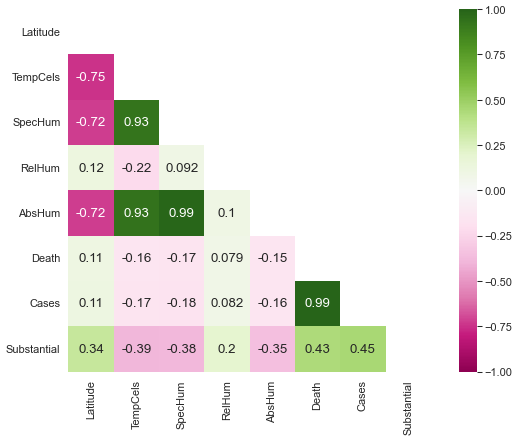

In [57]:
corr_mat(new_df, dict_font)

Temperature, specific and absolute humidities are strictly associated each other. All these weather variables are negatively associated with latitude. 

Death and cases are collinear, as expected.

#### Correlation plot

Scatterplots strafied by country with substantial and not substantial transmission of Covid-19, is useful to have an heuristic idea of the behaviour of the phenomeon in both groups.

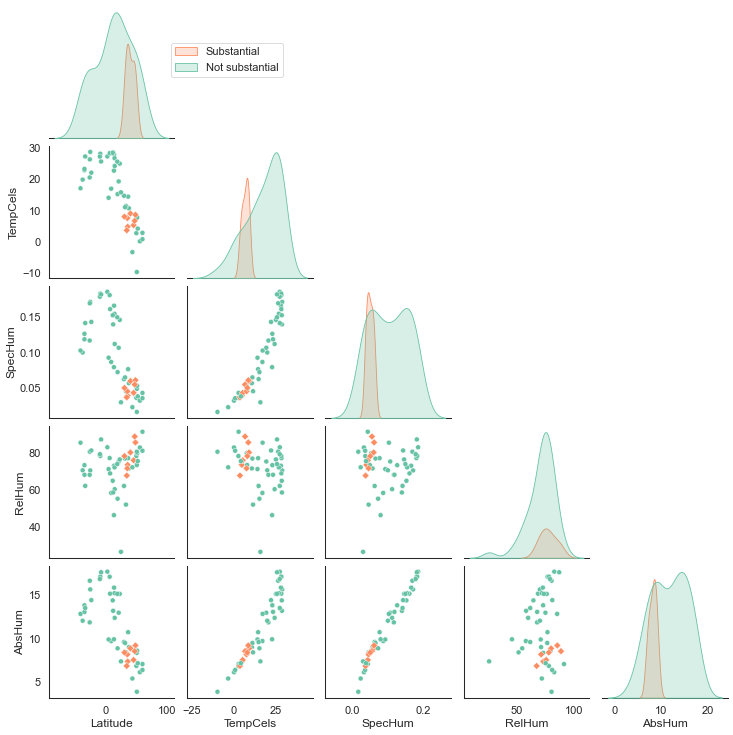

In [58]:
corr_sub(new_df, dict_font)

From the results one can notice that countries with substantial transmission have similar values for all variables. Despite this, the group doesn't form a cluster that's perfectly separated from other cities.

### Histograms

Distributions of deaths and cases are really asymetric. A plot of the log-transformation could be useful to check if the resulting distribution can be reconducted (approximately) to a gaussian. 

#### Log cases histogram

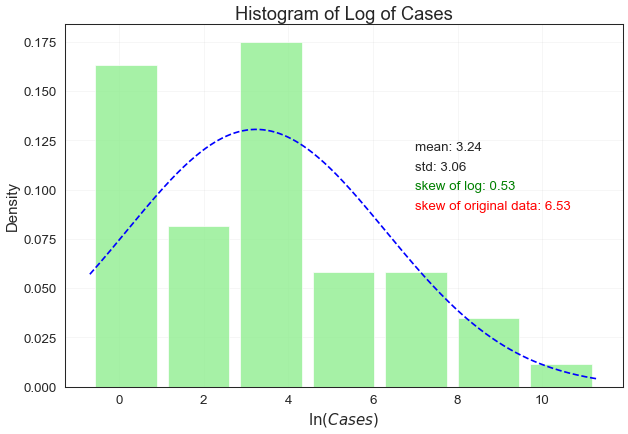

In [59]:
my_var = np.array(new_df["Cases"]).astype(float)
my_var[my_var==0] = 0.5
my_var = np.log(my_var)

hist_cases(my_var, new_df, dict_font)

#### Log deaths histogram

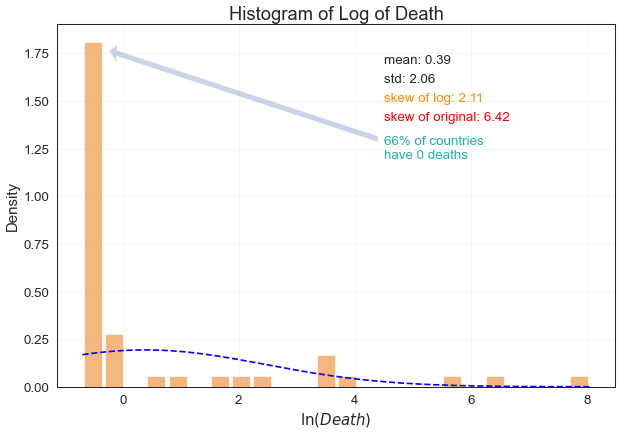

In [60]:
my_var = np.array(new_df["Death"]).astype(float)
my_var[my_var==0] = 0.5
my_var = np.log(my_var)

hist_death(my_var, new_df, dict_font)

### Regression Trees

A CART is a supervised learning method. However, since every split is based on a criterion of entropy, we can use it to identify most important variables in terms of data explanation. 
Variable importance increases as higher is the capacity of discriminate between observations. 

Error measures can be viewed as a goodness of fit of the tree. Then they can be interpreted as an index of realiability of the discriminatory power of variables.

####  Regression Tree without hold out

MSE:  65060301.332
MAPE:  2.1229110814924076e+16
MAE:  19.607
Mean and median are different (asymmetric distribution). 
Thus also the error measures are significantly different.
Color of the leaf corresponds to the predicted value


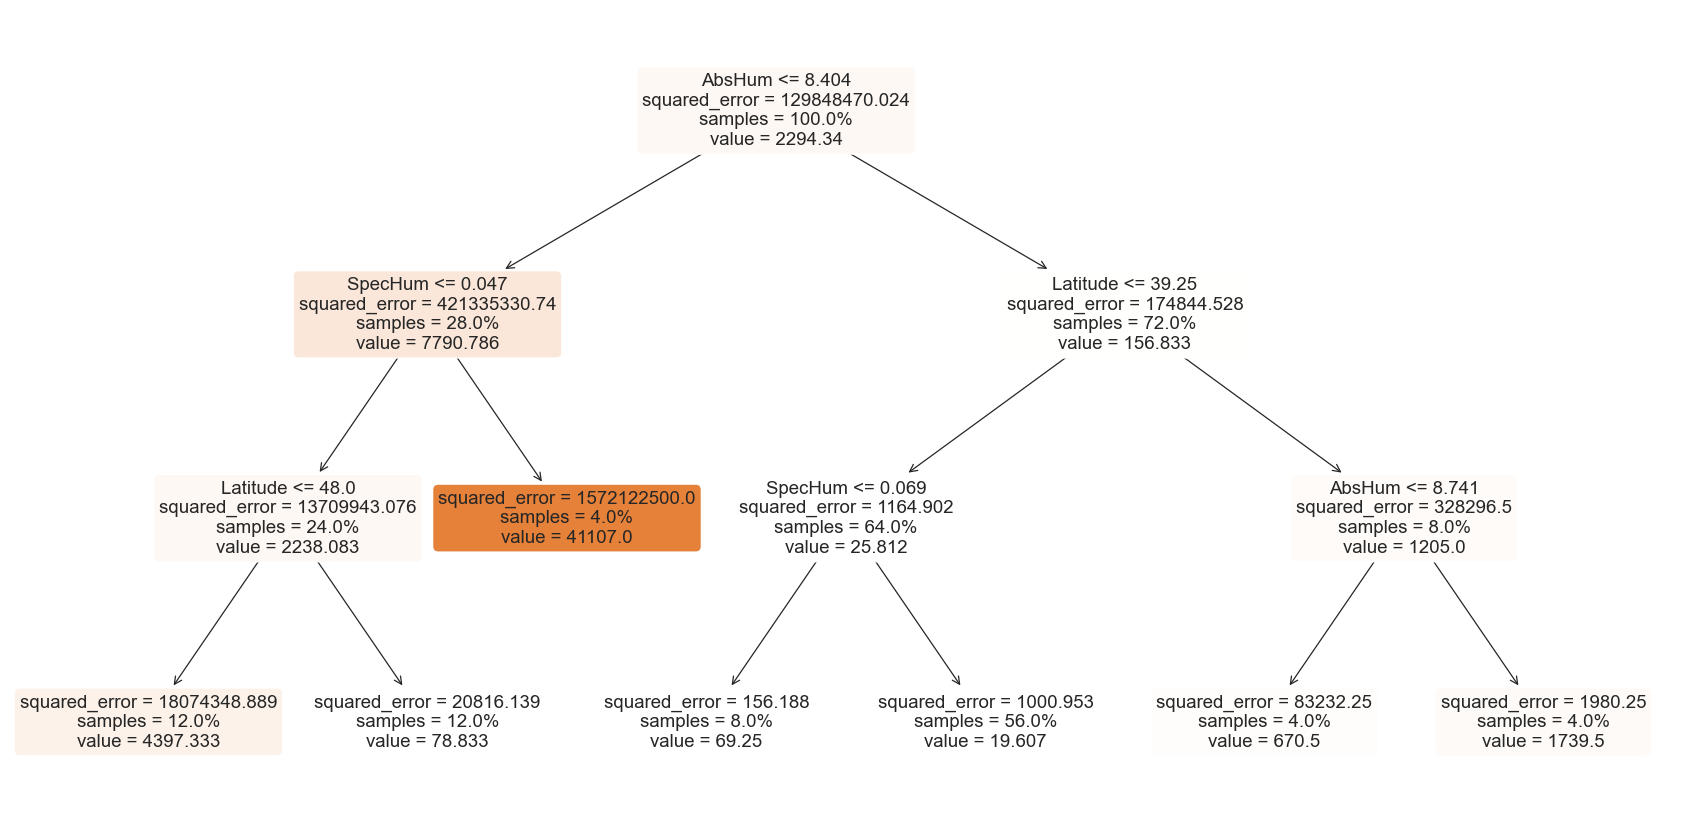

In [61]:
clf = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 2)
tree1(new_df, clf, dict_font)

#### Regression Tree with hold out

Since a in-sample validation can be misleading, the process is repeated with an hold-out validation.

Test MSE:  11919643.72
Test MAPE:  8430738502437571.0
Test MAE:  75.8
Unusual behavior: MSE is higher when using same train and test.


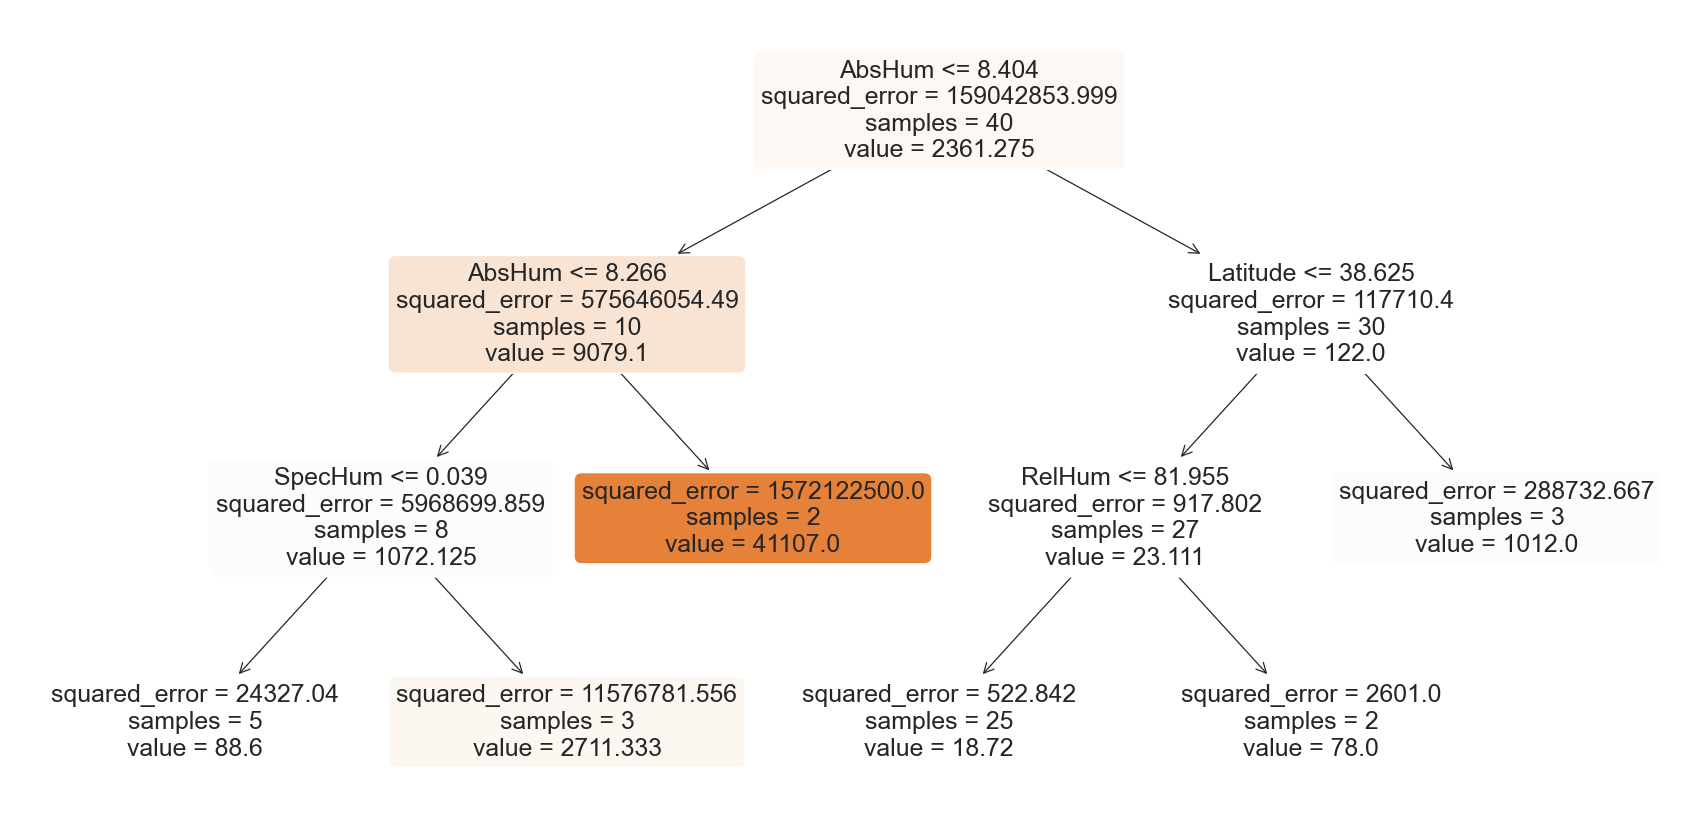

In [62]:
tree2(new_df, clf, dict_font)

### Time series

To investigate the seasonality of the respiratory infection, one can have a look at the time series. 

In [63]:
# Options
opts = pd.DataFrame({ "Var": ["t2m", "d2m", "sp"],
                      "Label": ["Temperature", "Dew Point", "Surface Pressure"],
                      "Unit": ["Celsius", "Celsius", "Pascal"]
                     })

#### Temperature time series

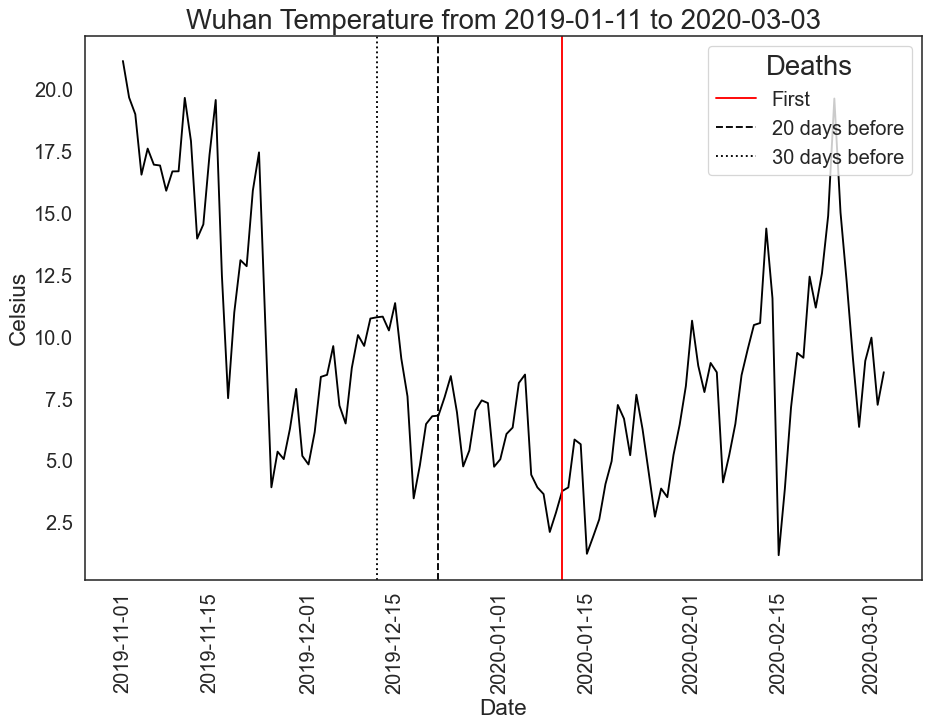

In [64]:
my_plot_ts(city = "Wuhan", var = "t2m", sub_df = sub_df, opts = opts, scale = 1)

The red line indicates the occurrance of first reported deaths, while the black dotted lines are placed respectively twenty and thirty days before.

A loop can plot time series for each city.

In [65]:
#plt.rcParams['figure.dpi'] = dict_font["fig_dpi"] * 1
#fig = plt.figure(figsize = np.array(dict_font["fig_size"]) * [1,1])
#cities_list_plot = sub_df["City"].astype(str).to_list()
#for current_city in cities_list_plot:
#    my_plot_ts(city = current_city, var = "t2m", sub_df = sub_df, opts = opts, scale = 0.80)

## Analysis

### Linear Regression

Once the EDA is complete, it's possible to introduce some models.

In [66]:
%run a3_analysis.ipynb

The subscript analysis contains code to produce graphs and models.

#### Log total cases and temperature

The dependent variable is the log-transform of cases to deal with strong asymmetry of the distribution. 

When using the <i>statmodels</i> OLS function, it’s necessary to add a column of ones to the regressor matrix to include the constant in the model.

R square: 0.25332
Intercept: 5.63074
Slope: -0.15056


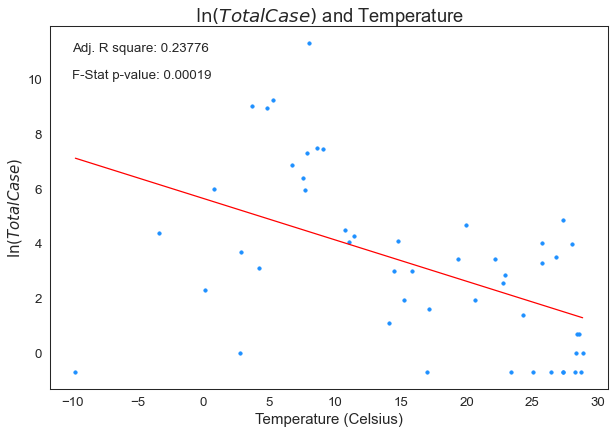

In [67]:
linearreg_temperature(new_df, dict_font)

The model is $$ {\ln( Cases)}= 5.63074 - 0.15056 \cdot Temperature $$

The relation is negative.

#### Log total cases and relative humidity

R square: 0.03655
Intercept: -0.49317
Slope: 0.05158


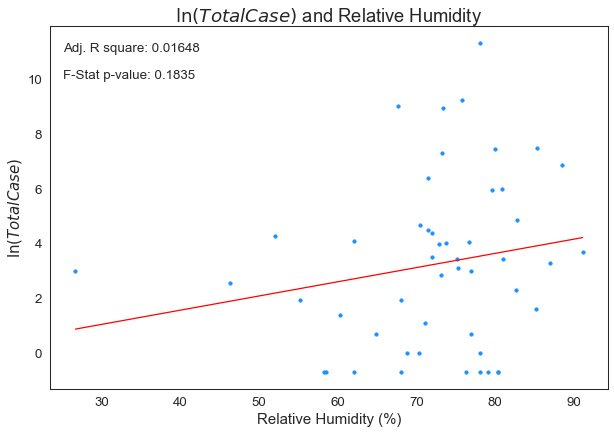

In [68]:
linearreg_hum(new_df, dict_font)

The model is: $$ {\ln( Cases)}=-0.493 + 0.052 \cdot RelativeHumidity $$
The relation is positive.

If the independent variable is relative humidity then the measures of goodness of fit are slightly less satisfying.

#### Temperature and substantial trasmission

Notice that the independent variable <i>Substantial </i>is binary, thus it represents the mean change in the dependent variable when an observation belongs to the group of substantial transmission.

Boxplot can lead to misleading conclusions about sparsity. A stripplot can be a good alternative because it is able to represent the density.

R square: 0.15405
Intercept: 17.64637
Slope: -10.93528


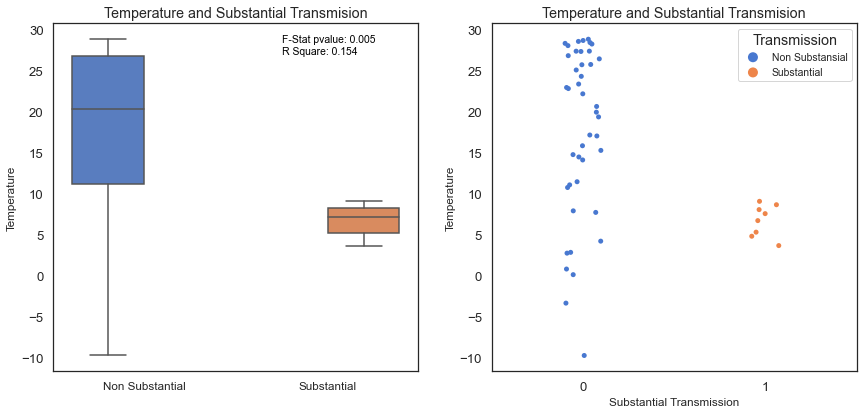

In [69]:
plot_sub(new_df, dict_font)

The model is $$ Temperature=17.64637 - 10.93528 \cdot Substantial $$

From the result we can notice that temperature is higher in countries with non substantial transmission. 

However, since the ranges are really different, we could have to face a problem of heteroskedasticity (frequent when distributions are skewed).

### Mann Whitney tests

Mann-Whitney is a non parametric test for independent sample. It can be used to check wheter the two samples are likely to be generated from the same distribution. The null hypothesis states that the samples come from the same distribution. 

Mann-Whitney test relies on the hypothesis of normal distribution in both groups. Shapiro test is used to check this assumption. 

The set $\alpha$ is 0.05.


In [70]:
# Options
opts = pd.DataFrame({ "Var": ["TempCels", "RelHum", "SpecHum"],
                      "Label": ["Temperature", "Relative Humidity", "Specific Humidity"],
                      "Unit": ["Celsius", "%", "g/Kg"]
                     })

nonsub_df = new_df.loc[new_df["Substantial"] == 0]

#### Temperature

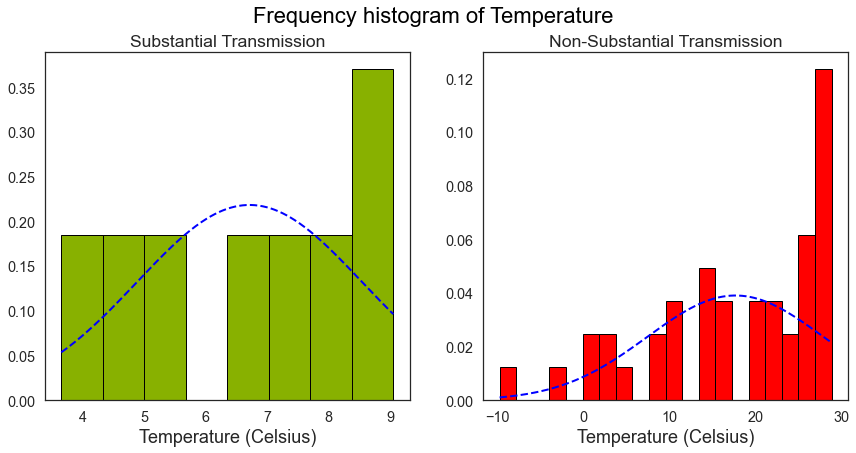

In [71]:
df_nonpar, _ = mw("TempCels", sub_df, nonsub_df, opts, dict_font)

In [72]:
print(df_nonpar)

                      test    pvalue
0      Shapiro Substantial  0.617948
1  Shapiro Non Substantial  0.001148
2             Mann-Whitney  0.003367


Since p-value of Mann-Whitney test is lower than $\alpha$, we reject the hypothesis that samples are from same distribution. 
However the result of Shapiro for non substantial group test suggest that Mann-Whitney result isn't reliable.

The color of the histogram is associated to the evidence against the null hypothesis: the palette ranges from green (when p-value is high) to red (when p-value is low). So, more red is the histogram, less likely is that data are generated from normal distribution.

#### Relative humidity

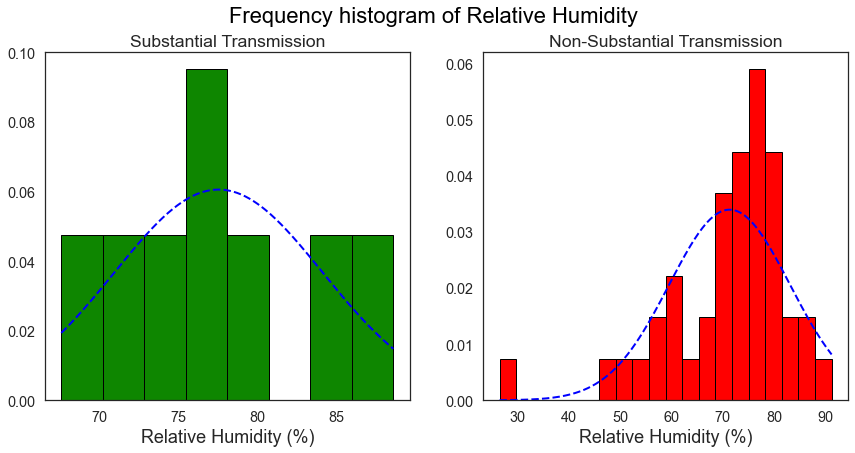

In [73]:
df_nonpar, _ = mw("RelHum", sub_df, nonsub_df, opts, dict_font)

In [74]:
print(df_nonpar)

                      test    pvalue
0      Shapiro Substantial  0.947708
1  Shapiro Non Substantial  0.001085
2             Mann-Whitney  0.203503


Since p-value of Mann-Whitney test is higher than $\alpha$, we don't reject the hypothesis that samples are from same distribution. 
However the result of Shapiro for non substantial group test suggest that Mann-Whitney result isn't reliable.

#### Specific humidity

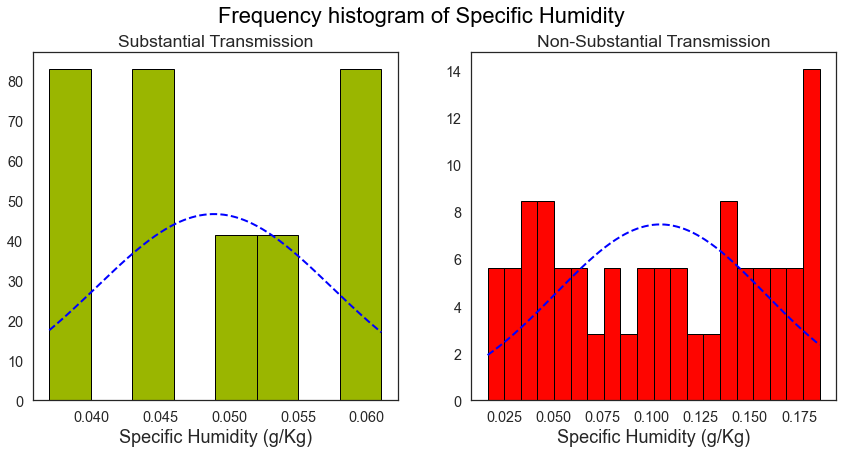

In [75]:
df_nonpar, _ = mw("SpecHum", sub_df, nonsub_df, opts, dict_font)

In [76]:
print(df_nonpar)

                      test    pvalue
0      Shapiro Substantial  0.576056
1  Shapiro Non Substantial  0.012170
2             Mann-Whitney  0.011293


Since p-value of Mann-Whitney test is lower than  𝛼, we don't reject the hypothesis that samples are from same distribution. However the result of Shapiro for non substantial group test suggest that Mann-Whitney result isn't reliable.

### Scatterplots

####  Temperature vs relative humidity

Two important variables are temperature and relative humidity. Then the association between these two covariates is indagated. There two distinct groups: countries with substantial or non substantial transmission.

Countries classes are created based on quartiles of Cases. This feature will be involved in scatterplot.

In [77]:
new_df["Size"] = pd.qcut(new_df["Cases"], 4, labels=['1', '2', '3', '4']) 
new_df["Size"] = pd.to_numeric(new_df["Size"]) * 100

The dimension of scatter point represent the quartile of cases in which lies the observation. 
Note that all countries with more than 10 deaths lies in fourth quartile.


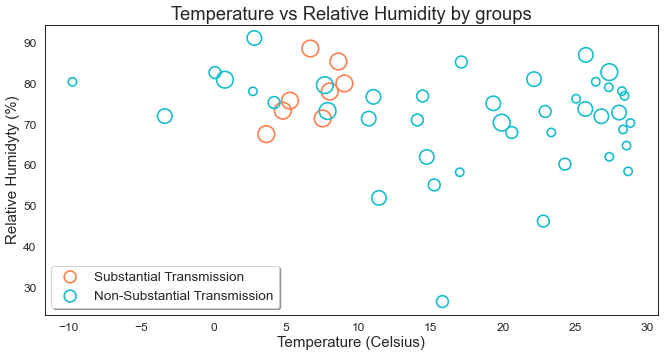

In [78]:
scatter_temperature_relhum(new_df, dict_font)

#### Temperature vs specific humidity

Alternatively, class can be created considering orders of magnitude.

In [79]:
new_df["Size"] = pd.cut(new_df["Cases"], right = False, # bin values into descrete intervals
                        bins = [0, 1, 10, 100, 1000, 10000, 100000], 
                        labels = list(np.array([1, 2, 3, 4, 5, 6]) * 20)) 

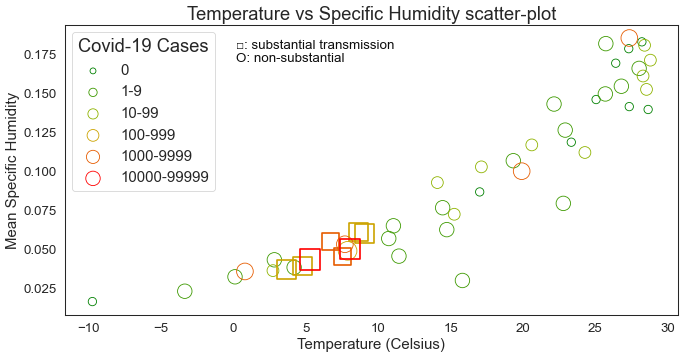

In [80]:
scatter_temperature_spechum(new_df, dict_font)

From this scatterplot we can derive at least two interesting confirms. 
<ol>
  <li> Countries with substantial transmission have similar values of temperature and specific humidity. The period is, approximately, February 2020.</li>
  <li> Temperatures in substantial group aren't outliers and vary from 3.5 to 9 Celsius degrees.</li>
</ol>

### World map

The goal is to create a world map. A color scale based on temperature is defined. Blue represents cold cities and red hottest ones.

In [81]:
create_world(geo_info, new_df)

Markers point cities in the group of Substantial Transmission. It's possible to notice that points lie roughly in similar meridian.
The size of the oval represent the number of confirmed deaths. The dimension of the biggest bubble corresponds to Wuhan, the epicenter of the pandemic.

## Advanced techniques

In [82]:
%run a4_advanced_techniques.ipynb

### Balancing: oversampling

The dataset is unbalanced: there are only 8 cities out of 50 with substantial transmission. 

As a possible solution the balancing techniques have been applied. The method of oversampling has been used because the dataset is small. 

The goal is to randomly create observation with substantial transmission, similar to the 8, in order to have 50% in both classes.

In [83]:
print(Counter(new_df["Substantial"]))
print("Percentage of substantial transmission:", new_df[new_df["Substantial"] == 1].shape[0]/new_df.shape[0]*100, "%")

Counter({0: 42, 1: 8})
Percentage of substantial transmission: 16.0 %


In [84]:
ros = RandomOverSampler() 
ros_df, substantial_ros = ros.fit_resample(new_df[["Latitude", "TempCels", "SpecHum", "RelHum", "AbsHum", "Death", "Cases"]], new_df["Substantial"]) # new class distribution 
print(Counter(substantial_ros))
# input of ros.fit_resample are X, matrix to resample and y, array of labels
# output are X_resampled and y_resampled

Counter({0: 42, 1: 42})


#### CART on Random Over Sampled dataset 

Test MSE:  10783107.981
Test MAPE:  8830272126522946.0
Test MAE:  75.482


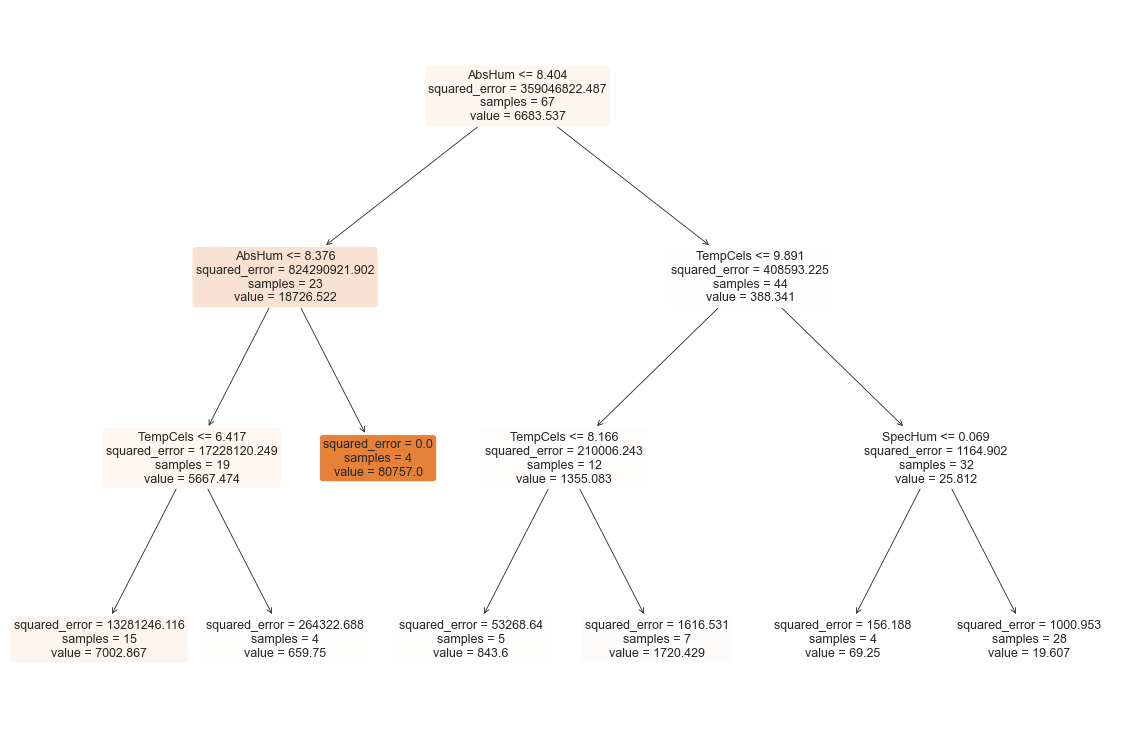

In [85]:
clf = tree.DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 2)
ros_tree(new_df, ros_df, clf, dict_font)

The mean square error is very high, but lower when compared to the previous trees. 
The variable which is the best in the spitting rule is the absolute humidity.


#### Linear regression on Random Over Sampled dataset

Notice that training set is the Random Over Sampled dataset and test set is the original unbalanced dataset.

In [86]:
ros_reg(new_df, ros_df)

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.378
Date:                Thu, 10 Feb 2022   Prob (F-statistic):              0.245
Time:                        16:06:01   Log-Likelihood:                -751.40
No. Observations:                  67   AIC:                             1515.
Df Residuals:                      61   BIC:                             1528.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Latitude    -106.7598    137.715     -0.775      0.4

Also with the balanced dataset, none of the variables result statistically significant in the model. 
Furthermore, the $R^2$ is very low. 

Since correlations between specific, absolute humidity and temperature are at least 90% one can face problems due to multicollinearity.  

### Clustering: K-means

The aim is to partition the observations in k clusters in which each observation belongs to the cluster with the nearest centroid. 

K-means cluster method minimizes within cluster variance: observations in different clusters should be dissimilar but observations in same cluster should not.

Variables have been standardized in advance. 

A major issue in k-means is the choiche of number of clusters k.

In [87]:
scaler = StandardScaler()
climate_df = new_df[["Latitude", "TempCels", "SpecHum", "RelHum", "AbsHum"]] 
scaled_array = scaler.fit_transform(climate_df) # mean = 0, var = 1

# output is a array, convert to df
scaled_df = pd.DataFrame(scaled_array, columns = climate_df.columns ) 

#### Elbow method

First the Elbow rule of thumb has been used to get the best number of clusters k. 
The method consists in plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.


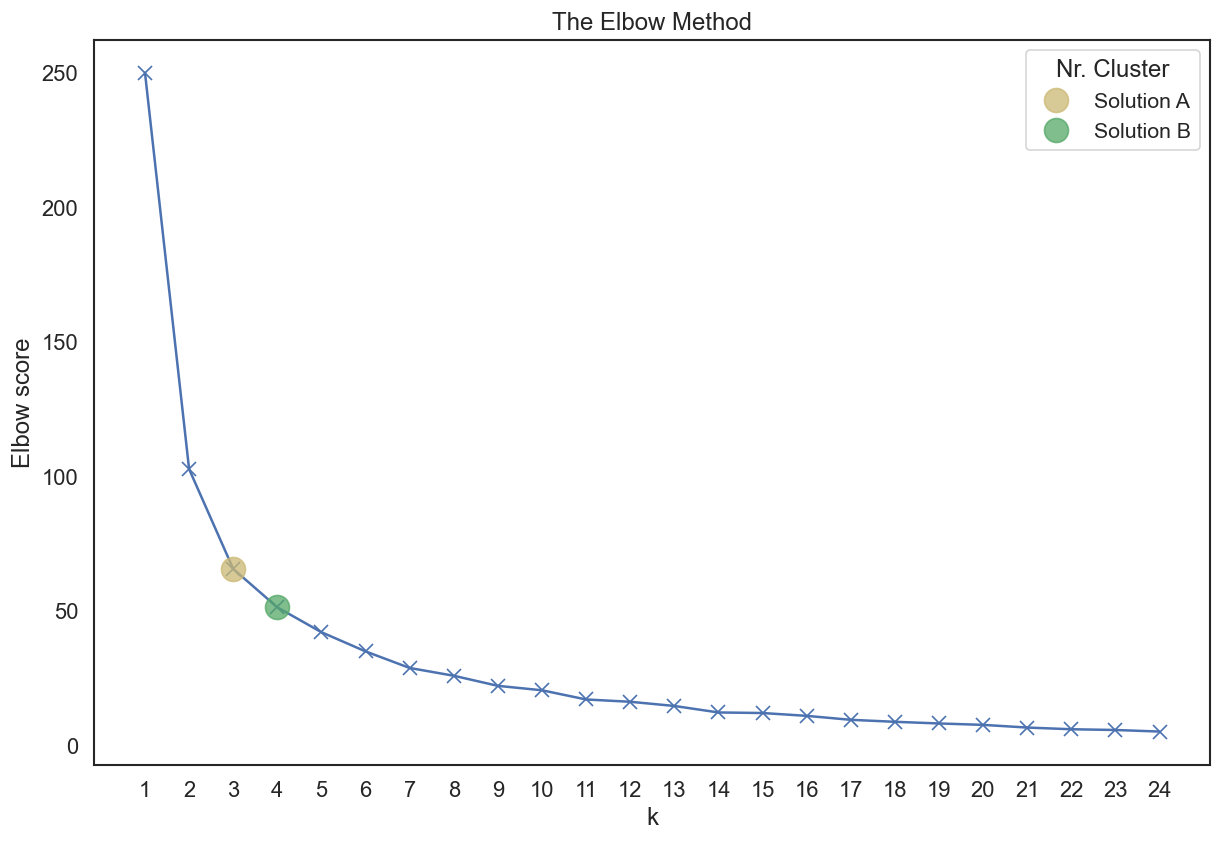

In [88]:
#import warnings
#warnings.filterwarnings('ignore')
kmeans_elbow(scaled_df, dict_font)

As one can notice, the best number of k can be 3 or 4. 

#### Silhouette analysis

Then, a silhouette method has been involved. The silhouette for an observation varies from −1 to +1. High values mean that the unit is well matched to its own cluster.

The silhouette method is usually more precise then the elbow rule, so we rely on the former. 

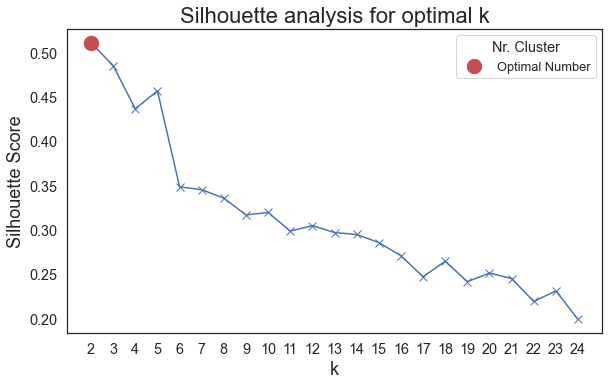

In [89]:
_, silhouette_scores = kmeans_silhouette(scaled_df, dict_font)

The best k is 2. Silhouette's value for a certain number of cluster k is the mean of the values of whole sample.

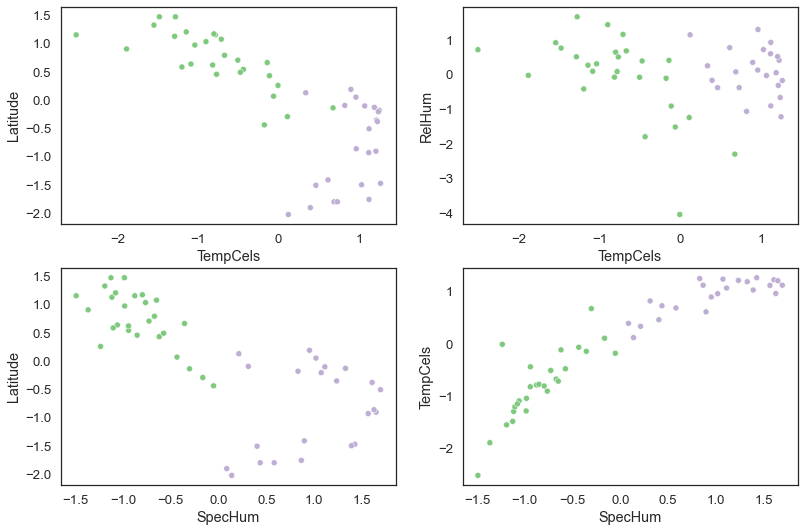

In [90]:
kmeans_plot(scaled_df, silhouette_scores, dict_font)

Clusters are not perfectly separated. Observations in same cluster are sparse.

### Ridge Regression

Ridge regression is a method to shrink coefficients estimates toward zero.

Variables have been standardized in advance.

Ridge regression is similar to OLS, and includes a penalty in the quantity to be minimized:  $RSS+\alpha \sum{\beta_j^2}$ where $\alpha$ is a tuning parameter. When $\alpha=0$, the ridge regression produces the least squares estimate. If $\alpha$ increases, coefficients estimates will approach zero, then the bias increase so the variance decreases (<b>bias-variance tradeoff</b>).

In [91]:
# scaler = StandardScaler()
standardized_df = new_df[["Latitude", "TempCels", "SpecHum", "RelHum", "AbsHum","Cases"]] 
standardized_array = scaler.fit_transform(standardized_df)

standardized_df = pd.DataFrame(standardized_array, columns = standardized_df.columns )

X_train, X_test, y_train, y_test = train_test_split(standardized_df[["Latitude", "TempCels", "SpecHum", "RelHum", "AbsHum"]], 
                                                    standardized_df["Cases"], test_size = 0.2, random_state = 1) 

An array of values of $\alpha$ ranging from big to small is generated. Then, the best is chosen using the hold-out validation.

The difference between <i>scaled_df</i>, used in clustering, and <i>standardized_df</i>, used in robust regression, is that the first one doesn't contain the response variable <i>Cases</i>.

In [92]:
ridge(X_train, X_test, y_train, y_test)

Penalties tested: 250
Numbers of predictors: 5
Best alpha:  189.3578
Test MSE: 0.092
Intercept: β0 = 0.013
Latitude: β1 = 0.008
TempCels: β2 = -0.023
SpecHum: β3 = -0.026
RelHum: β4 = 0.019
AbsHum: β5 = -0.022


The Ridge regression works quite good: some of the coefficients were shrinked toward zero. 
Anyway, the best alpha is a big value, this means that the variables are not closely linearly related to the response and the penalty is huge. 

### Lasso

The lasso works in the same way of the Ridge regression except that the quantity to minimize is $RSS+\alpha \sum{ \left| \beta_j  \right| }$.

Moreover, lasso regression shrinks coefficients estimates exactly to zero.

In [93]:
lasso(X_train, X_test, y_train, y_test)

Penalties tested: 250
Numbers of predictors: 5
Best alpha:  0.1249
MSE: 0.091
Intercept: β0 = 0.012
Latitude: β1 = 0.0
TempCels: β2 = -0.0
SpecHum: β3 = -0.07
RelHum: β4 = 0.0
AbsHum: β5 = -0.0


Lasso performs better then ridge regression, since that coefficients are shrinked to zero. 
Only the coefficient of the specific humidity is not equal to zero. 
Anyway, alpha is very close to zero. 


### Feature Selection

By performing feature selection one can decrease the error measures. 

Usually some variables are not useful to predict the response, moreover some can be correlated between them (<i>multicollinearity</i>).

To perform subset selection, a separate OLS is performed for each possible combination of the <i>p</i> predictors. The goal is to identify the best subset.

The used technique is the <b>forward subset selection</b>, which has computational advantages.

In [94]:
fs_coeff, models_best = feature_selection(X_train, X_test, y_train, y_test)

In [95]:
print(fs_coeff.to_string(index = False, header = True))

 Nr Coef      RSS
       1 0.850012
       2 0.850063
       3 0.953649
       4 1.256265
       5 1.647067
       6 2.914109


The table shows the models RSS with 1, 2, 3, 4, 5 coefficients. 

The lower RSS is the one associated to the model with only one predictor. 

In [96]:
print(models_best.loc[np.argmin(models_best["RSS"]) + 1, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                  Cases   R-squared (uncentered):                   0.009
Model:                            OLS   Adj. R-squared (uncentered):             -0.016
Method:                 Least Squares   F-statistic:                             0.3715
Date:                Thu, 10 Feb 2022   Prob (F-statistic):                       0.546
Time:                        16:06:07   Log-Likelihood:                         -60.625
No. Observations:                  40   AIC:                                      123.2
Df Residuals:                      39   BIC:                                      124.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The best predictor is the latitude, even though the p-value is not statistically significant. 

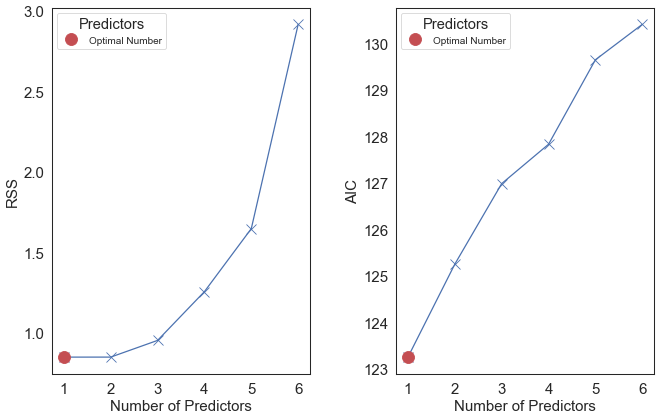

In [97]:
plot_fs(models_best, dict_font)

The best model in term of RSS and AIC is the one with 1 predictor.

## Conclusions

Firstly we tried to replicate the analysis of the paper. It suggests that there's is an association between temperature, latitutude and spread of Covid-19. 

Furthermore, we investigate the phenomenon in depth with other techniques. However there are considerable limitations.

In fact some results of the paper are not reliable. Collection date of death and cases is too close to the discovery of the spread around the world. In 03/10/2020, most countries were not able to diagnose cases and deaths.

An interesting further development of the analysis would be to replicate it by using more recent data. In this way we could be able to assert if the disease is seasonal or not.

Moreover maybe other variables affect diffusion of the virus, e.g. population density, pollution, health systems, demographic characteristics. 